## Predict the demand for bike share using known tools (cont.)

### Recreating data from last class

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# sample data
bike_data = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2023/data/bike_sharing_demand/bike_sample.csv")
features = bike_data.drop(columns=["count", "registered", "casual"]).select_dtypes(include=np.number)
label = bike_data["count"]

prng = np.random.RandomState(20240306)
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=prng)

# feature engineered data
def extract_dt_features(df_with_datetime):
    df_with_datetime['datetime'] = pd.to_datetime(df_with_datetime['datetime'], utc=True)
    df_with_datetime['year'] = df_with_datetime['datetime'].dt.year
    df_with_datetime['day'] = df_with_datetime['datetime'].dt.day
    df_with_datetime['month'] = df_with_datetime['datetime'].dt.month
    df_with_datetime['hour'] = df_with_datetime['datetime'].dt.hour
    df_with_datetime['dayofweek'] = df_with_datetime['datetime'].dt.dayofweek


extract_dt_features(bike_data)

feature_matrix = bike_data.drop(columns=["count", "registered", "casual"]).select_dtypes(include=np.number)
label = bike_data["count"]
prng = np.random.RandomState(20240306)
X_train_fe, X_test_fe, y_train, y_test = train_test_split(feature_matrix, label, test_size=0.2, random_state=prng)

# full data
bike_full = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2023/data/bike_sharing_demand/train.csv")
extract_dt_features(bike_full)

full_data_without_original_test = bike_full.loc[~bike_full.datetime.isin(bike_data.filter(X_test.index, axis=0)['datetime'])]
full_data_without_original_test.shape

X_full = full_data_without_original_test.drop(columns=["count", "registered", "casual", "datetime"])
y_full = full_data_without_original_test['count']

### Evaluation function

In [2]:
# define loss function
def calculateRMSLE(prediction, y_obs):
    return round(np.sqrt(
        np.mean(
            (
                np.log(np.where(prediction < 0, 0, prediction) + 1) - 
                np.log(y_obs + 1)
            )**2
        )
    ), 4)

### Model #5: Tree

In [4]:
from sklearn.pipeline import Pipeline
from sklearn import tree

steps = [
    ("tree", tree.DecisionTreeRegressor(max_depth=5, random_state=prng))
]
pipe_tree = Pipeline(steps)

models = ["Tree", "Feature engineered tree", "Feature engineered tree large n"]
datasets = [
    (X_train, y_train, X_test),
    (X_train_fe, y_train, X_test_fe),
    (X_full, y_full, X_test_fe)
]

tree_results = []

for model, data in zip(models, datasets):

    pipe_tree.fit(data[0], data[1])

    train_error = calculateRMSLE(pipe_tree.predict(data[0]), data[1])
    test_error = calculateRMSLE(pipe_tree.predict(data[2]), y_test)

    tree_result = [model, train_error, test_error]
    tree_results.append(tree_result)

pd.DataFrame(tree_results, columns = ["Model", "Train", "Test"])

,Model,Train,Test
0,Tree,1.3021,1.3094
1,Feature engineered tree,0.6092,0.5956
2,Feature engineered tree large n,0.6078,0.5610


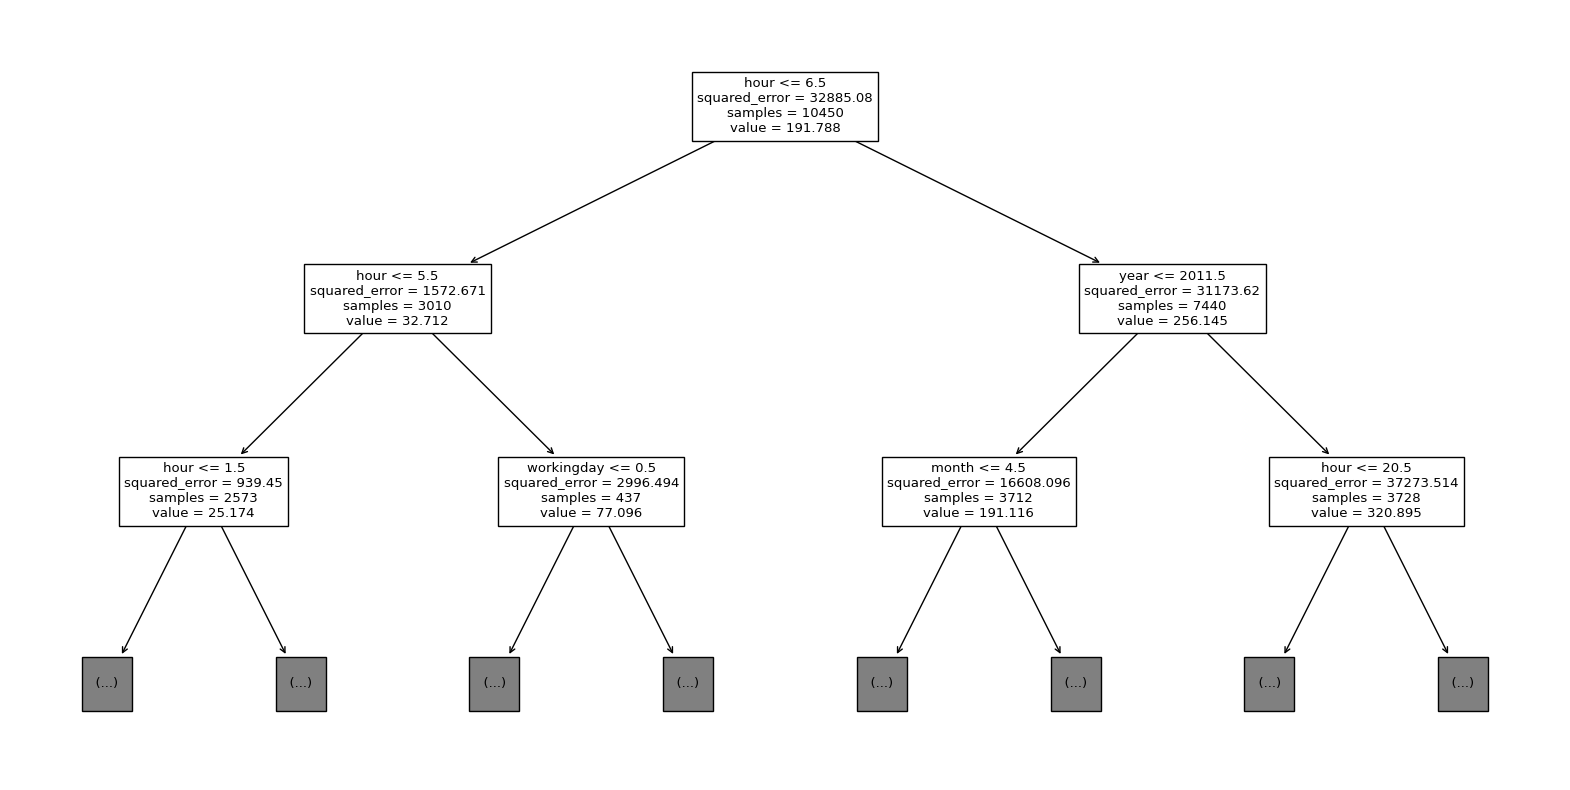

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
tree.plot_tree(pipe_tree["tree"], feature_names = X_full.columns.to_list(), max_depth=2)
plt.show()

In [12]:
# TODO: fit a more appropriate model
steps = [
    ("tree", tree.DecisionTreeRegressor(max_depth=31, random_state=prng))
]
pipe_deep_tree = Pipeline(steps)

models = ["Deep tree", "Feature engineered deep tree", "Feature engineered deep tree large n"]
datasets = [
    (X_train, y_train, X_test),
    (X_train_fe, y_train, X_test_fe),
    (X_full, y_full, X_test_fe)
]

deep_tree_results = []

for model, data in zip(models, datasets):

    pipe_deep_tree.fit(data[0], data[1])

    train_error = calculateRMSLE(pipe_deep_tree.predict(data[0]), data[1])
    test_error = calculateRMSLE(pipe_deep_tree.predict(data[2]), y_test)

    tree_result = [model, train_error, test_error]
    deep_tree_results.append(tree_result)

pd.DataFrame(deep_tree_results, columns = ["Model", "Train", "Test"])

,Model,Train,Test
0,Deep tree,0.2337,1.5497
1,Feature engineered deep tree,0.0000,0.5468
2,Feature engineered deep tree large n,0.0000,0.4100


**Lessons:**

- A simple tree can capture complex (non-linear) relationships (we achieved much better performance than with the cumbersome LASSO without any tweaks). This does not mean that LASSO is useless, only that the tree seems to be a much better fit for this problem.
- More data did not really help the shallow tree (`max_depth=5`) because it was not complex enough -- it did help the deep tree but also led to massive overfitting on the sample dataset (compare the test set performance of the two tree models on the sample dataset).
- Actually, the deep tree overfits on all datasets as test error is always larger than the train error; however, it is less of a problem until the test error is still better than with the less complex model. It would be a good exercise to choose the `max_depth` parameter by cross-validation.

### Model #6: Random forest

#### Default settings

In [7]:
# random forest
from sklearn.ensemble import RandomForestRegressor

steps = [
    ("random_forest", RandomForestRegressor())
]
pipe_rf = Pipeline(steps)

models = ["RF", "Feature engineered RF", "Feature engineered RF large n"]

rf_results = []

for model, data in zip(models, datasets):

    pipe_rf.fit(data[0], data[1])

    train_error = calculateRMSLE(pipe_rf.predict(data[0]), data[1])
    test_error = calculateRMSLE(pipe_rf.predict(data[2]), y_test)

    rf_result = [model, train_error, test_error]
    rf_results.append(rf_result)

pd.DataFrame(rf_results, columns = ["Model", "Train", "Test"])

,Model,Train,Test
0,RF,0.8073,1.3011
1,Feature engineered RF,0.2127,0.4130
2,Feature engineered RF large n,0.1457,0.2827


In [9]:
pipe_rf["random_forest"].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

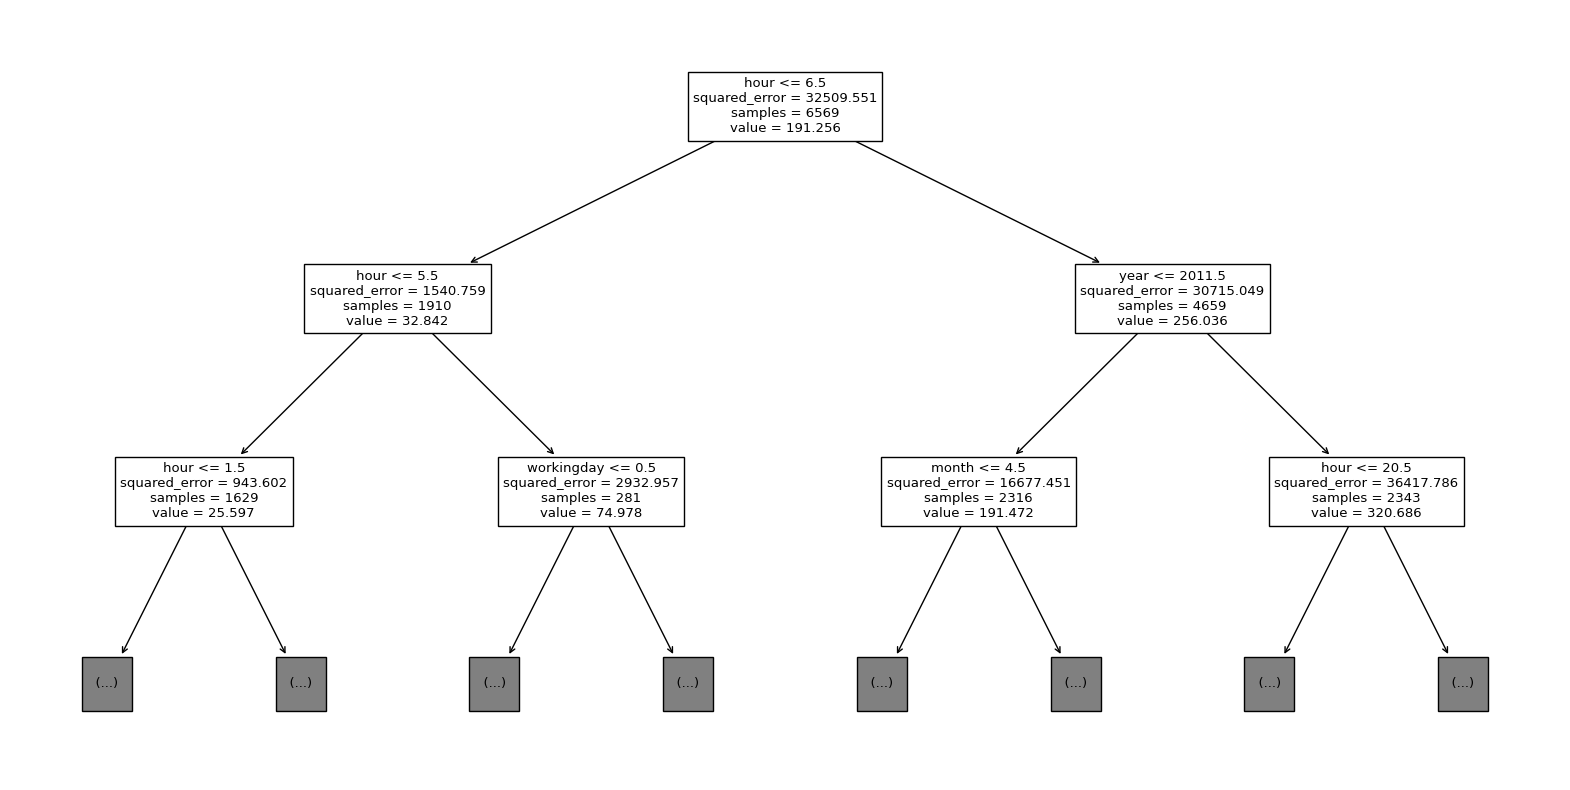

In [10]:
# Look at single trees
chosen_tree = pipe_rf["random_forest"].estimators_[0]
plt.figure(figsize=(20,10))
tree.plot_tree(chosen_tree, feature_names = X_full.columns.to_list(), max_depth=2)
plt.show()

In [11]:
(chosen_tree.tree_.max_depth, chosen_tree.tree_.node_count)

(31, 12387)

**Lessons:**

- Interestingly, the default `RandomForestRegressor` does not randomly choose from the features at each split (as `max_features = n_features`). Also, there is no restricition on the size of the tree (`max_depth = None, max_leaf_nodes: None, min_samples_leaf = 1, min_samples_split: 2`).
- Each tree within the random forest completely memorizes the training data. However, as each of them uses a bootstrapped sample of the training data, the aggregated prediction won't be perfect. This illustrates that bootstrapping in itself is a means of generalisation.

#### Hyper-parameter tuning

In [13]:
# hyper-parameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = [0.05, 0.5, 0.7, 1.0]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000],
 'max_features': [0.05, 0.5, 0.7, 1.0],
 'max_depth': [1, 25, 50, 75, 100, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [ ]:
# NOTE! This cell requires sklearn 1.4+
# WARNING! This cell might take several minutes to run. Decrease `n_iter` to make it quicker (and less thorough)

# hyper-parameter tuning - fit the models on the full sample
rf = RandomForestRegressor(random_state=prng)

# Random search of parameters, using 5 fold cross validation,
# search across n_iter different combinations, and use all available cores, evaluate by RMSLE
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=50, cv=5, scoring="neg_root_mean_squared_log_error", verbose=2, random_state=prng, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_full, y_full)

In [15]:
rf_random.best_params_

{'n_estimators': 890,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 1.0,
 'max_depth': 100,
 'bootstrap': True}

In [16]:
pd.DataFrame(rf_random.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.387416,0.025275,0.298953,0.011413,1000,10,4,0.05,25,True,"{'n_estimators': 1000, 'min_samples_split': 10...",-1.429829,-1.137654,-1.129776,-1.021395,-0.920797,-1.127890,0.170584,41
1,12.035829,0.089988,0.119590,0.004627,340,10,2,0.7,75,False,"{'n_estimators': 340, 'min_samples_split': 10,...",-0.798458,-0.395965,-0.518611,-0.354339,-0.345337,-0.482542,0.169624,2
2,1.874729,0.015629,0.077104,0.003904,670,2,2,0.5,1,False,"{'n_estimators': 670, 'min_samples_split': 2, ...",-1.779431,-1.275773,-1.414757,-1.170554,-1.106676,-1.349438,0.238965,45
3,1.931169,0.016521,0.073057,0.002759,230,2,2,0.05,75,True,"{'n_estimators': 230, 'min_samples_split': 2, ...",-1.379045,-1.091021,-1.082265,-1.010292,-0.879275,-1.088380,0.163923,31
4,14.482143,0.062851,0.263683,0.018147,670,5,2,0.5,None,True,"{'n_estimators': 670, 'min_samples_split': 5, ...",-0.895630,-0.536998,-0.614076,-0.427468,-0.372495,-0.569333,0.183515,23
5,7.351179,0.078351,0.305864,0.021914,890,5,4,0.05,100,False,"{'n_estimators': 890, 'min_samples_split': 5, ...",-1.404609,-1.130585,-1.088981,-0.989231,-0.891637,-1.101009,0.172930,35
6,3.797906,0.139469,0.130042,0.004508,1000,10,1,0.05,1,True,"{'n_estimators': 1000, 'min_samples_split': 10...",-1.913842,-1.413251,-1.605586,-1.369982,-1.311991,-1.522930,0.218889,47
7,2.016195,0.022609,0.076559,0.002043,230,10,2,0.05,None,False,"{'n_estimators': 230, 'min_samples_split': 10,...",-1.396902,-1.111539,-1.089512,-0.976590,-0.880169,-1.090942,0.174092,32
8,3.216712,0.044178,0.043267,0.002886,120,10,2,0.7,None,True,"{'n_estimators': 120, 'min_samples_split': 10,...",-0.821384,-0.403687,-0.544079,-0.360678,-0.346142,-0.495194,0.177468,9
9,1.691006,0.023031,0.069989,0.002450,230,2,4,0.05,75,True,"{'n_estimators': 230, 'min_samples_split': 2, ...",-1.418739,-1.125232,-1.128626,-1.026070,-0.926714,-1.125076,0.164560,40


In [17]:
train_error = calculateRMSLE(rf_random.best_estimator_.predict(X_full), y_full)
test_error = calculateRMSLE(rf_random.best_estimator_.predict(X_test_fe), y_test)
cv_rf_result = ["CV RF large n", train_error, test_error]

rf_results.append(cv_rf_result)
pd.DataFrame(rf_results, columns = ["Model", "Train", "Test"])

,Model,Train,Test
0,RF,0.8073,1.3011
1,Feature engineered RF,0.2127,0.4130
2,Feature engineered RF large n,0.1457,0.2827
3,CV RF large n,0.1447,0.2805


### Model #7: XGBoost

#### Technical detour: category type

In [19]:
dummy_features = ["season", "holiday", "workingday", "weather", "year", "month", "day", "hour", "dayofweek"]
X_full[dummy_features] = X_full[dummy_features].astype("category")
X_full.dtypes

season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
year          category
day           category
month         category
hour          category
dayofweek     category
dtype: object

Why we did not deal with this so far? Because sklearn's implementation of trees [does not handle them differently](https://scikit-learn.org/stable/modules/tree.html#:~:text=and%20categorical%20data.-,However%2C%20the%20scikit%2Dlearn%20implementation%20does%20not%20support%20categorical%20variables%20for%20now.,-Other%20techniques%20are).

In [21]:
# Illustration
pipe_tree.fit(X_full, y_full)

train_error = calculateRMSLE(pipe_tree.predict(X_full), y_full)
test_error = calculateRMSLE(pipe_tree.predict(X_test_fe), y_test)

tree_results.append(["Tree large n categories", train_error, test_error])

pd.DataFrame(tree_results, columns = ["Model", "Train", "Test"])

,Model,Train,Test
0,Tree,1.3021,1.3094
1,Feature engineered tree,0.6092,0.5956
2,Feature engineered tree large n,0.6078,0.5610
3,Tree large n categories,0.6078,0.5610


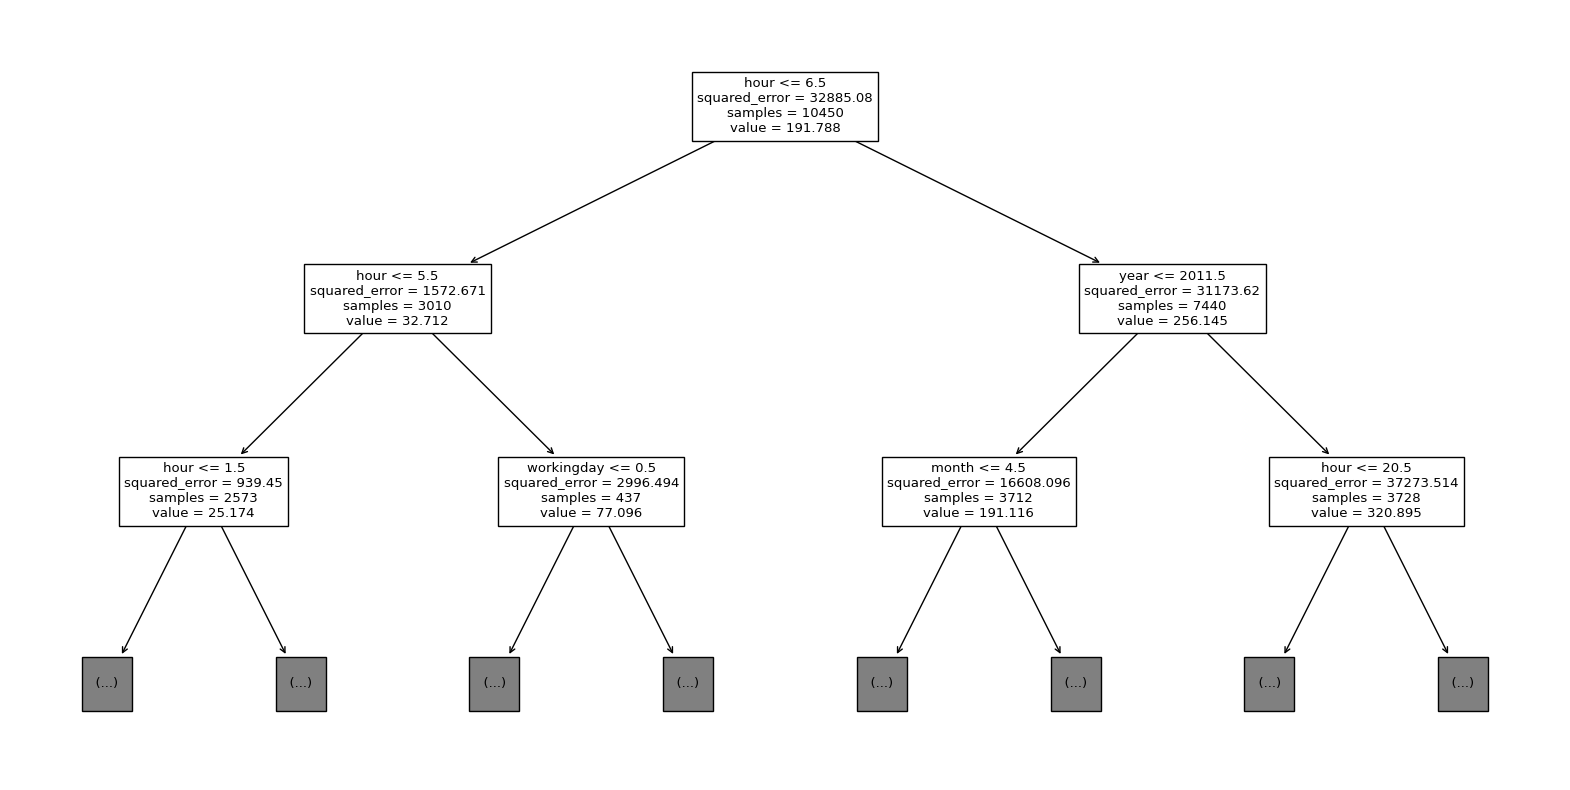

In [22]:
plt.figure(figsize=(20,10))
tree.plot_tree(pipe_tree["tree"], feature_names = X_full.columns.to_list(), max_depth=2)
plt.show()

In [23]:
# Boosted tree: xgboost
import xgboost as xgb
xgb_model = xgb.XGBRegressor(enable_categorical=True).fit(X_full, y_full)

In [25]:
train_error = calculateRMSLE(xgb_model.predict(X_full), y_full)
test_error = calculateRMSLE(xgb_model.predict(X_test_fe), y_test)

["XGB", train_error, test_error]

['XGB', 0.3587, 0.6816]

In [39]:
xgb_model.get_booster().trees_to_dataframe().head(10)

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,hour,NaN,0-2,0-1,0-1,123864184.0,10450.0,"[0, 1, 2, 3, 4, 5, 6, 22, 23]"
1,0,1,0-1,hour,NaN,0-4,0-3,0-3,35166384.0,6562.0,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14..."
2,0,2,0-2,hour,NaN,0-6,0-5,0-5,4799192.0,3888.0,"[0, 1, 2, 3, 4, 5]"
3,0,3,0-3,workingday,NaN,0-8,0-7,0-7,18107248.0,1319.0,[0]
4,0,4,0-4,year,NaN,0-10,0-9,0-9,19066454.0,5243.0,[0]
5,0,5,0-5,temp,19.68,0-11,0-12,0-12,1137855.0,1315.0,None
6,0,6,0-6,hour,NaN,0-14,0-13,0-13,481496.0,2573.0,"[2, 3, 4, 5]"
7,0,7,0-7,year,NaN,0-16,0-15,0-15,15280192.0,900.0,[0]
8,0,8,0-8,hour,NaN,0-18,0-17,0-17,3922304.5,419.0,[8]
9,0,9,0-9,temp,15.58,0-19,0-20,0-20,9532252.0,2633.0,None


**Lessons:**

- "Both xgboost and gbm follows the principle of gradient boosting. There are however, the difference in modeling details. Specifically, xgboost used a more regularized model formalization to control over-fitting, which gives it better performance." [Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- xgboost can handle categorical values, resulting in rules defined by sets instead of simple numerical cuts

### Submit to Kaggle

Kaggle provides a test set without any labels. Our task is to predict these labels and submit to Kaggle which will evaluate our model's performance based on its evaluation metric (RMSLE in this case).

In [38]:
bike_test = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2023/data/bike_sharing_demand/test.csv")
extract_dt_features(bike_test)

to_submit = pd.DataFrame({
    'datetime': bike_test.datetime.dt.strftime('%Y-%m-%d %H:%M:%S'),
    'count': pipe_rf.predict(bike_test.drop(columns=["datetime"]))
})

to_submit.to_csv("/Users/i525503/teaching/ceu-ml/data/bike_sharing_demand/submission1.csv", index=False)

**Lessons:**

- Our performance is much worse than expected based on our own test set (which we split from the original train set and thus had labels to measure the performance). Why is this? Because our test set was not a good representation of the real test set. We just picked some rows at random (specific hours for bike share demand), whereas in Kaggle we had to predict demand for specific days (the end of each month). Thus, our sloppy method for splitting the test set made us think we knew more than we actually did, and thus made us overly optimistic about our predictions. Make sure you split your data carefully, otherwise you might end up with models that are better at memorization than generalization.

## Predict heart failure

We are going to work with a heart disease data set collected from 5 different sources (for more detailed information consult [Kaggle](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)). It contains health condition data about 918 patients and whether they got a heart attack. We will use the subset of this dataset and preserve the rest for evaluating our final model on Kaggle in a [mini in-class competition](https://www.kaggle.com/competitions/ceuml2-heart-failure/overview).

Cardiovascular diseases (CVDs) are [the most common cause of death globally](https://ourworldindata.org/cardiovascular-diseases) making this task particularly relevant. As the competition states: _"People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors) need early detection and management wherein a machine learning model can be of great help."_

Attribute Information:
- `Age`: age of the patient [years]
- `Sex`: sex of the patient [M: Male, F: Female]
- `ChestPainType`: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- `RestingBP`: resting blood pressure [mm Hg]
- `Cholesterol`: serum cholesterol [mm/dl]
- `FastingBS`: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- `RestingECG`: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- `MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]
- `ExerciseAngina`: exercise-induced angina [Y: Yes, N: No]
- `Oldpeak`: oldpeak = ST [Numeric value measured in depression]
- `ST_Slope`: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- `HeartDisease`: output class [1: heart disease, 0: Normal]

You can either download the data from Kaggle and load it directly, or use the versions on GitHub.

In [4]:
import os

current_dir = os.getcwd()

heart_data = pd.read_csv("../data/heart_failure/heart_train.csv")

### Know your data

In [17]:
heart_data.shape

(643, 12)

In [18]:
heart_data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

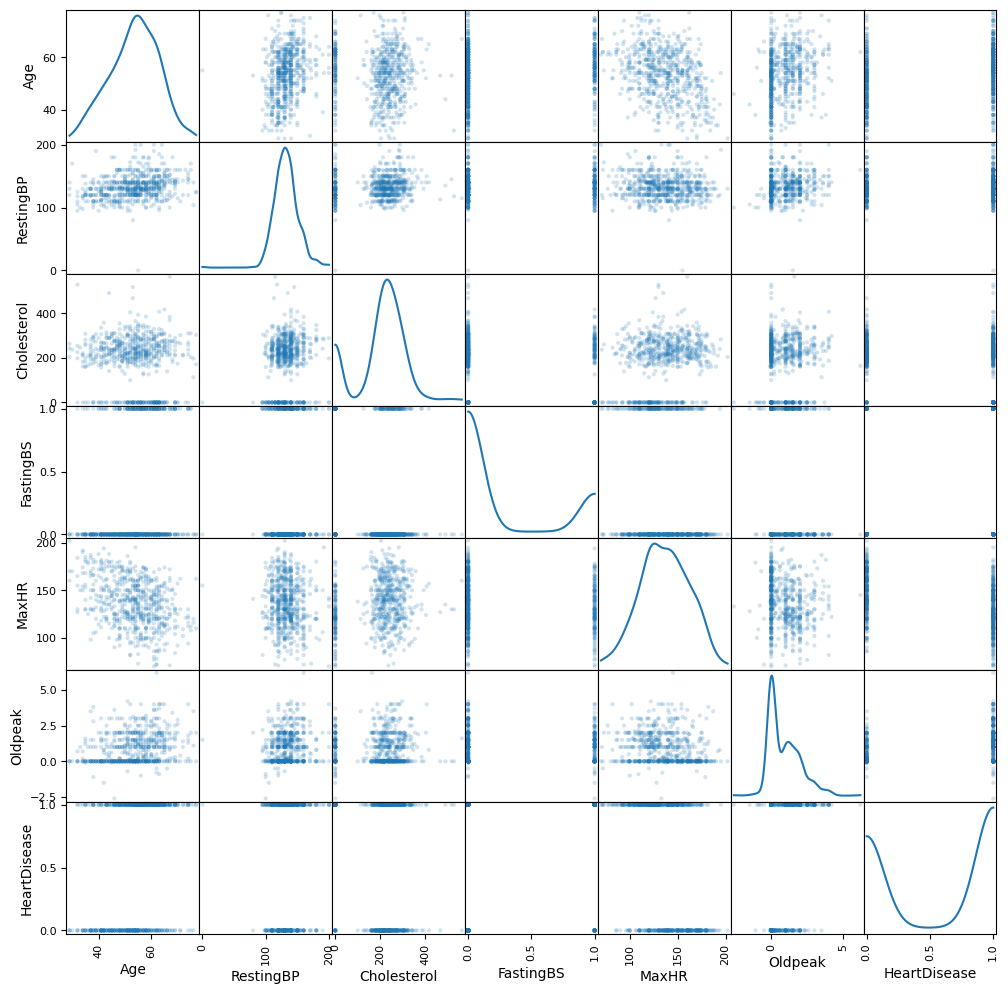

In [19]:
from pandas.plotting import scatter_matrix
scatter_matrix(heart_data, alpha=0.2, figsize=(12, 12), diagonal="kde");

### Train-test split

In [5]:
features = heart_data.drop(columns=["HeartDisease"])
label = heart_data["HeartDisease"]

prng = np.random.RandomState(20240311)
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=prng)

### Benchmark evaluation

In [11]:
# benchmark accuracy
from sklearn.metrics import accuracy_score

def calculateAccuracy(observed, predicted):
    return round(accuracy_score(observed, predicted), 4)

benchmark_prediction = np.bincount(y_train).argmax()
train_accuracy = calculateAccuracy(y_train, np.repeat(benchmark_prediction, len(y_train)))
test_accuracy = calculateAccuracy(y_test, np.repeat(benchmark_prediction, len(y_test)))
[train_accuracy, test_accuracy]

[0.5447, 0.6589]

In [22]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, np.repeat(benchmark_prediction, len(y_test)))
cm

array([[ 0, 44],
       [ 0, 85]])

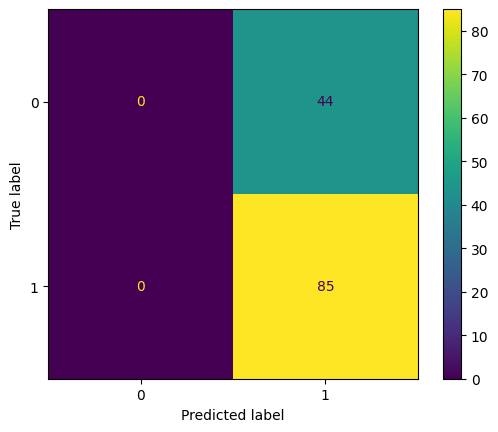

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
plt.show()

In [12]:
from sklearn.metrics import precision_score, recall_score

def calculateMetrics(observed, predicted):
    return {
        "accuracy": calculateAccuracy(observed, predicted),
        "precision": round(precision_score(observed, predicted), 4),
        "recall": round(recall_score(observed, predicted), 4)
    }

pd.DataFrame(
    [calculateMetrics(y, np.repeat(benchmark_prediction, len(y))) for y in [y_train, y_test]],
    index=["Train", "Test"]
)

,accuracy,precision,recall
Train,0.5447,0.5447,1.0
Test,0.6589,0.6589,1.0


**Lessons:**

- Predicting everyone as having a heart failure gives a seemingly good accuracy of over 65% on the test set. However, this is only due the unbalanced set, where most of the patients in test have a failure. If we are predicting a rare event, a straightforward 'no event' prediction coult result in an accuracy of over 99%.
- This is why we look at two other metrics: Recall (same as True Positive Rate: how many of the positive outcomes are correctly predicted as positives) and Precision (True Positives over all Positive predictions: what share of the positive predictions are correct). The recall of the straightforward prediction is clearly one, its precision is equal to the prevalance (which, in this case, equals to the accuracy).

### Benchmark #2: Logistic regression

#### Pipeline with preprocessing and estimation

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

one_hot_encoder = OneHotEncoder(sparse_output=False, drop="first")
categorical_vars = heart_data.select_dtypes(include="object").columns.to_list()

column_transformer = ColumnTransformer(
    [("create_dummies", one_hot_encoder, categorical_vars)],
    remainder="passthrough"
)

In [7]:
# logit
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipe_logit = Pipeline([
    ("preprocess", column_transformer),
    ("scale", MinMaxScaler()),
    ("logit", LogisticRegression(penalty=None))
])
pipe_logit.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('create_dummies',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('scale', MinMaxScaler()),
                ('logit', LogisticRegression(penalty=None))])

In [27]:
pipe_logit.predict(X_train)

array([0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,

In [28]:
pd.DataFrame(
    [calculateMetrics(y, pipe_logit.predict(x)) for x, y in [(X_train, y_train), (X_test, y_test)]],
    index=["Train", "Test"]
)

,accuracy,precision,recall
Train,0.8774,0.8754,0.9036
Test,0.8915,0.9610,0.8706


#### ROC curve

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. The `predict()` method uses a default threshold of 0.5 to generate class predictions from the model. To uncover the original predicted probabilities instead, we need to use the `predict_proba()` method.
See e.g. [this](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) for more detail on ROC.

In [31]:
# To use a different cutoff we need to predict probabilities first
pipe_logit.predict_proba(X_train)[:10, :]  # look at first 10 results

array([[0.94478902, 0.05521098],
       [0.08449756, 0.91550244],
       [0.01168867, 0.98831133],
       [0.02406516, 0.97593484],
       [0.18996398, 0.81003602],
       [0.22368605, 0.77631395],
       [0.0937171 , 0.9062829 ],
       [0.9807124 , 0.0192876 ],
       [0.92013655, 0.07986345],
       [0.06682772, 0.93317228]])

In [13]:
def predictProbs(model, X):
    return model.predict_proba(X)[:, 1]

def predictWithCutoff(model, X, cutoff):
    return (predictProbs(model, X) >= cutoff).astype(int)

cutoff = 0.3
pd.DataFrame(
    [calculateMetrics(y, predictWithCutoff(pipe_logit, x, cutoff)) for x, y in [(X_train, y_train), (X_test, y_test)]],
    index=["Train", "Test"]
)

,accuracy,precision,recall
Train,0.8716,0.8386,0.9464
Test,0.8915,0.9277,0.9059


Decreasing the cutoff, we are more lenient to predict someone as having a failure. Thus, recall increased - and, as a price to pay, precision decreased.

In [37]:
# ROC
from sklearn.metrics import roc_curve, roc_auc_score

y_scores = predictProbs(pipe_logit, X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores) 
print(f"thresholds: {thresholds}\n")
print(f"FPR: {fpr}\n")
print(f"TPR: {tpr}\n")

thresholds: [       inf 0.99295523 0.95848204 0.9564946  0.80953785 0.80158159
 0.70077138 0.68870408 0.57697687 0.45762832 0.45637473 0.42129762
 0.31636173 0.29436733 0.29354547 0.24525274 0.21727806 0.15512611
 0.14260807 0.09295632 0.0919786  0.07455706 0.07207841 0.02986436
 0.02713588 0.00651601]

FPR: [0.         0.         0.         0.02272727 0.02272727 0.04545455
 0.04545455 0.06818182 0.06818182 0.11363636 0.11363636 0.13636364
 0.13636364 0.18181818 0.18181818 0.20454545 0.20454545 0.22727273
 0.22727273 0.31818182 0.31818182 0.36363636 0.36363636 0.70454545
 0.70454545 1.        ]

TPR: [0.         0.01176471 0.29411765 0.29411765 0.69411765 0.69411765
 0.8        0.8        0.87058824 0.87058824 0.88235294 0.88235294
 0.90588235 0.90588235 0.91764706 0.91764706 0.95294118 0.95294118
 0.96470588 0.96470588 0.97647059 0.97647059 0.98823529 0.98823529
 1.         1.        ]



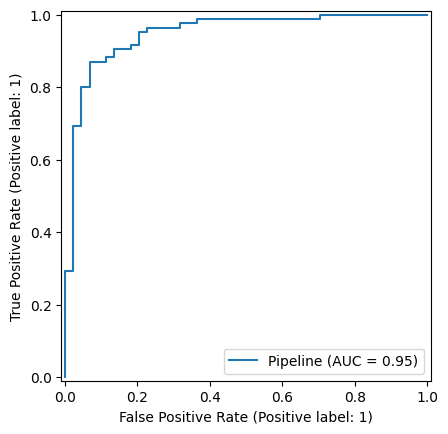

In [38]:
from sklearn.metrics import RocCurveDisplay

roc_display = RocCurveDisplay.from_estimator(pipe_logit, X_test, y_test)
plt.show(roc_display)

#### Precision-recall plot

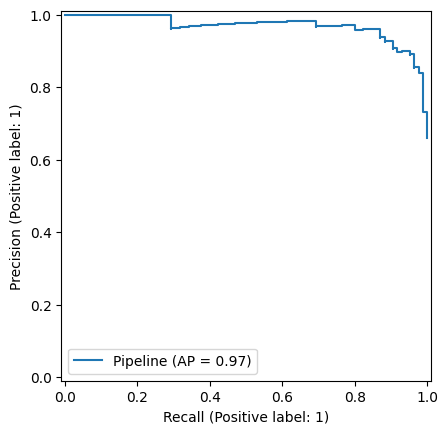

In [39]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

PrecisionRecallDisplay.from_estimator(pipe_logit, X_test, y_test)

#### Imputation

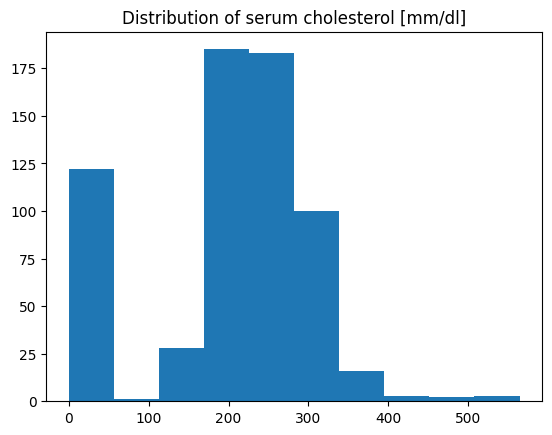

In [41]:
plt.hist(heart_data["Cholesterol"])
plt.title("Distribution of serum cholesterol [mm/dl]")
plt.show()

As we can see, there are many zero readings for cholesterol in the blood. These values are unlikely to be true. It is better to treat them as missing values. A common strategy for missing values (which you did in DA3) is to flag them explicitly. Another is imputation. In the next section we impute zero values by taking the average of the nearest neighbours.

In [42]:
# Imputation
from sklearn.impute import KNNImputer

change_zero_cholesterol_to_closest_neighbors = KNNImputer(missing_values=0)

column_transformer_with_imputation = ColumnTransformer(
    [
        ("create_dummies", one_hot_encoder, categorical_vars),
        ("impute_cholesterol", change_zero_cholesterol_to_closest_neighbors, ["Cholesterol"])
    ],
    remainder="passthrough"
)
pipe_logit_with_imputation = Pipeline([
    ("preprocess", column_transformer_with_imputation),
    ("scale", MinMaxScaler()),
    ("logit" , LogisticRegression(penalty=None, random_state=prng))
])
pipe_logit_with_imputation

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('create_dummies',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope']),
                                                 ('impute_cholesterol',
                                                  KNNImputer(missing_values=0),
                                                  ['Cholesterol'])])),
                ('scale', MinMaxScaler()),
                ('logit',
                 LogisticRegression(penalty=None,
                                    random_state=RandomState(MT19937) at 0x12758F640))])

In [43]:
pipe_logit_with_imputation.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('create_dummies',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope']),
                                                 ('impute_cholesterol',
                                                  KNNImputer(missing_values=0),
                                                  ['Cholesterol'])])),
                ('scale', MinMaxScaler()),
                ('logit',
                 LogisticRegression(penalty=None,
                                    random_state=RandomState(MT19937) at 0x12758F640))])

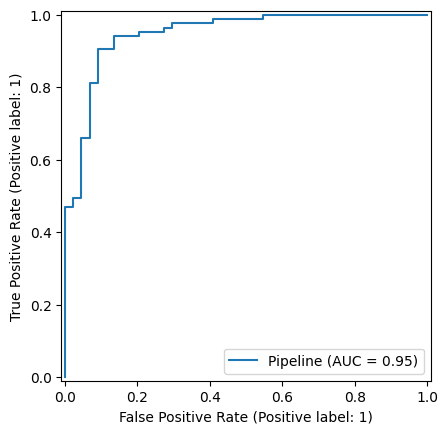

In [44]:
roc_display_imputed = RocCurveDisplay.from_estimator(pipe_logit_with_imputation, X_test, y_test)

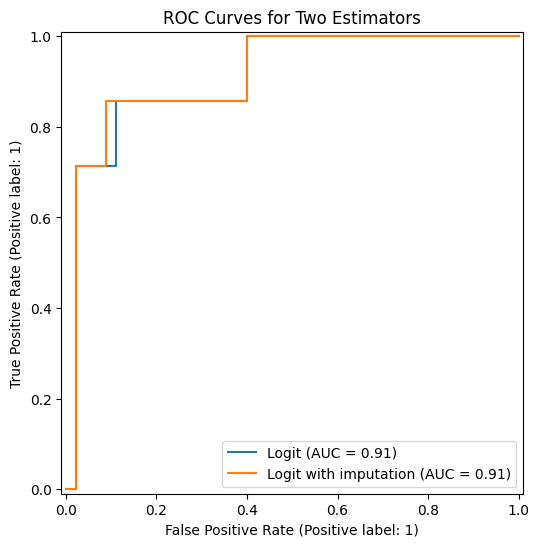

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))
roc_display.plot(ax=ax, name="Logit")
roc_display_imputed.plot(ax=ax, name="Logit with imputation")
plt.title('ROC Curves for Two Estimators')
plt.show()

### Submit to Kaggle

In [14]:
# Load the holdout set for the feature
heart_holdout = pd.read_csv("../data/heart_failure/heart_test.csv")

# Generate predictions for Kaggle
predictions = pd.DataFrame({
    "id": heart_holdout.index + 1,
    "HeartDisease": predictProbs(pipe_logit, heart_holdout)
})

predictions.to_csv("../data/heart_failure/submission1.csv", index=False)

### autoML
Some of the ML processes are easy to automate (e.g. hyper-parameter tuning, model evaluation and selection). There are many tools that solve this automation task, e.g. the [auto-sklearn package](https://automl.github.io/auto-sklearn/master/).